In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/drone-detection/tensorflow obj detection drone/README.dataset.txt
/kaggle/input/drone-detection/tensorflow obj detection drone/README.roboflow.txt
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_HELICOPTER_017241_127_png.rf.57bade93bbe2486cfecacffbe78b1284.jpg
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_AIRPLANE_02222_280_png.rf.49a96453d9ce0ae76dfc983586a8efaf.jpg
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_AIRPLANE_03838_039_png.rf.384e6e6b68bd915ced34087bf61bfe2c.jpg
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_HELICOPTER_021245_206_png.rf.be567da06a031e600ef7a90a41ff0391.jpg
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_DRONE_095205_137_png.rf.6a3b3cc55295ca0d7e8a4261d89fb27c.jpg
/kaggle/input/drone-detection/tensorflow obj detection drone/valid/V_DRONE_080190_026_png.rf.76d3db7e766bcd9b02ae9a9d9d72c206.jpg
/kaggle/input/drone-detection/tensorflow obj 

In [2]:
"""
Drone Detection with Faster R-CNN in PyTorch

This script trains a Faster R-CNN model with a ResNet-18 FPN backbone to detect
drones in a given dataset. The dataset is expected to be in COCO JSON format.

The workflow includes:
1.  Setting up configuration and logging.
2.  Defining a custom PyTorch Dataset with Albumentations for data augmentation.
3.  Creating DataLoaders for training, validation, and testing.
4.  Building the object detection model.
5.  Executing the training and evaluation loops.
6.  Saving the trained model weights.
7.  Visualizing predictions on the test set.
"""

'\nDrone Detection with Faster R-CNN in PyTorch\n\nThis script trains a Faster R-CNN model with a ResNet-18 FPN backbone to detect\ndrones in a given dataset. The dataset is expected to be in COCO JSON format.\n\nThe workflow includes:\n1.  Setting up configuration and logging.\n2.  Defining a custom PyTorch Dataset with Albumentations for data augmentation.\n3.  Creating DataLoaders for training, validation, and testing.\n4.  Building the object detection model.\n5.  Executing the training and evaluation loops.\n6.  Saving the trained model weights.\n7.  Visualizing predictions on the test set.\n'

In [3]:
# --- Core Libraries ---
import logging
import random
from pathlib import Path
import warnings

In [4]:
# --- Data Handling and Visualization ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image, ImageDraw, ImageFont

In [5]:
# --- PyTorch and Torchvision ---
import torch
import torch.optim as optim
import torchvision.ops as ops
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models import resnet18

In [6]:
# --- Augmentation and COCO Tools ---
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pycocotools.coco import COCO

# --- Configuration ---
from dataclasses import dataclass

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [7]:
# --- Initial Setup ---
warnings.filterwarnings("ignore")

In [8]:
# Configure logging for clear and informative outputs
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler()] # Outputs logs to the console
)
logger = logging.getLogger(__name__)


@dataclass
class DroneDetectionConfig:
    """Configuration class for the drone detection project."""
    # --- CORRECTED PATH ---
    # The original directory name contains spaces, not hyphens. This has been fixed.
    ROOT_DIR: Path = Path('/kaggle/input/drone-detection/coco json drone detection')
    
    # The rest of the paths are derived from ROOT_DIR and are correct.
    TRAIN_DIR: Path = ROOT_DIR / 'train'
    VALID_DIR: Path = ROOT_DIR / 'valid'
    TEST_DIR: Path = ROOT_DIR / 'test'
    
    # Model and Training Hyperparameters
    NUM_CLASSES: int = 4  # 3 drone classes + 1 background
    NUM_EPOCHS: int = 6
    BATCH_SIZE: int = 8
    LEARNING_RATE: float = 0.01
    MOMENTUM: float = 0.9
    WEIGHT_DECAY: float = 0.0005
    BOX_REG_LOSS_WEIGHT: float = 0.2 # Extra weight for box regression loss
    IMG_SIZE: int = 600
    # NUM_WORKERS: int = 4
    NUM_WORKERS: int = 0  # <--- THIS IS THE FIX
    
    # Prediction Visualization
    PREDICTION_SCORE_THRESHOLD: float = 0.5
    PREDICTION_IOU_THRESHOLD: float = 0.4
    
    # Output
    MODEL_SAVE_PATH: str = "fasterrcnn_drone_detector.pth"

In [9]:
# --- Data and Augmentation Utilities ---

def get_coco_instance(data_dir: Path) -> COCO:
    """Finds and loads the COCO JSON annotation file from a directory."""
    for file in data_dir.glob("*.json"):
        if file.is_file():
            logger.info(f"COCO annotation file found: {file}")
            return COCO(file)
    raise FileNotFoundError(f"No COCO JSON file found in {data_dir}")

def create_category_mappings(coco: COCO) -> tuple[dict, dict]:
    """Creates mappings from category ID to name and vice-versa."""
    cats = coco.loadCats(coco.getCatIds())
    id_to_cat = {cat['id']: cat['name'] for cat in cats}
    cat_to_id = {cat['name']: cat['id'] for cat in cats}
    logger.info(f"Created category mappings for: {list(cat_to_id.keys())}")
    return id_to_cat, cat_to_id

def get_transforms(is_train: bool, img_size: int) -> A.Compose:
    """Returns the appropriate data augmentation pipeline for train or validation/test."""
    if is_train:
        return A.Compose([
            A.Resize(img_size, img_size),
            A.HorizontalFlip(p=0.4),
            A.VerticalFlip(p=0.4),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))
    else:
        return A.Compose([
            A.Resize(img_size, img_size),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels']))

class DroneDataset(datasets.VisionDataset):
    """Custom PyTorch Dataset for Drone Detection."""
    def __init__(self, root: Path, split: str = 'train', transforms=None):
        super().__init__(root, transforms=transforms)
        self.split_dir = root / split
        self.coco = get_coco_instance(self.split_dir)
        self.ids = list(sorted(self.coco.getImgIds()))

    def _load_image(self, img_id: int):
        path = self.coco.loadImgs(img_id)[0]['file_name']
        return read_image(str(self.split_dir / path))

    def _load_target(self, img_id: int):
        anns = self.coco.loadAnns(self.coco.getAnnIds(imgIds=img_id))
        boxes = []
        labels = []
        for ann in anns:
            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])
            labels.append(ann['category_id'])
        
        target = {
            "boxes": torch.as_tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 4), dtype=torch.float32),
            "labels": torch.as_tensor(labels, dtype=torch.int64) if labels else torch.zeros((0,), dtype=torch.int64)
        }
        return target

    def __getitem__(self, index: int):
        img_id = self.ids[index]
        image = self._load_image(img_id)
        target = self._load_target(img_id)

        if self.transforms:
            image_np = image.permute(1, 2, 0).numpy()
            
            transformed = self.transforms(
                image=image_np,
                bboxes=target["boxes"],
                labels=target["labels"].tolist()
            )
            
            image = transformed["image"]
            target["boxes"] = torch.tensor(transformed["bboxes"], dtype=torch.float32)
            target["labels"] = torch.tensor(transformed["labels"], dtype=torch.int64)

        # --- FIX APPLIED HERE ---
        # The model expects a float tensor in the [0, 1] range.
        # ToTensorV2 returns a uint8 tensor in [0, 255], so we convert and normalize it.
        image = image.float() / 255.0

        return image, target

    def __len__(self) -> int:
        return len(self.ids)

def collate_fn(batch):
    """Custom collate function for object detection dataloader."""
    return tuple(zip(*batch))


In [10]:
# --- Model Definition ---

def create_detection_model(num_classes: int) -> FasterRCNN:
    """
    Creates a Faster R-CNN model with a pre-trained ResNet-18 FPN backbone.
    """
    # Load a pre-trained ResNet-18 backbone and specify the layers to use for FPN
    backbone = resnet18(pretrained=True)
    return_layers = {'layer2': '0', 'layer3': '1', 'layer4': '2'}
    in_channels_list = [128, 256, 512]
    out_channels = 256
    backbone_fpn = BackboneWithFPN(backbone, return_layers, in_channels_list, out_channels)
    
    # Define the anchor generator for the RPN
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,)),              
        aspect_ratios=((0.5, 1.0, 2.0),) * 4               
    )
    
    # Create the Faster R-CNN model
    model = FasterRCNN(
        backbone_fpn, 
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator
    )
    logger.info("Faster R-CNN model with ResNet-18 FPN backbone created.")
    return model

In [11]:
# --- Training and Evaluation Engine ---

def train_one_epoch(model, optimizer, data_loader, device, epoch, loss_reg_weight):
    """Runs a single training epoch."""
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1} [Training]")
    for images, targets in progress_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        loss = sum(l for l in loss_dict.values())
        
        # Apply extra weight to the box regression loss for better bounding boxes
        loss += loss_reg_weight * loss_dict["loss_box_reg"]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    return total_loss / len(data_loader)

def evaluate(model, data_loader, device, loss_reg_weight):
    """Runs evaluation on the validation or test set to calculate loss."""
    
    # --- THE FIX ---
    # Put the model in `train` mode. This is necessary to get the loss dictionary.
    # We wrap the entire process in `torch.no_grad()` to ensure no gradients are
    # computed and the model weights are not updated.
    model.train()
    
    total_loss = 0
    loss_components = {
        "loss_classifier": 0.0, "loss_box_reg": 0.0,
        "loss_objectness": 0.0, "loss_rpn_box_reg": 0.0
    }
    
    with torch.no_grad():
        progress_bar = tqdm(data_loader, desc="[Validation]")
        for images, targets in progress_bar:
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Now, model(images, targets) will correctly return a dictionary of losses
            loss_dict = model(images, targets)
            
            for key in loss_components:
                # This line will now work correctly
                loss_components[key] += loss_dict[key].item()

            loss = sum(l for l in loss_dict.values())
            loss += loss_reg_weight * loss_dict["loss_box_reg"]
            total_loss += loss.item()

    # Calculate average losses
    n_batches = len(data_loader)
    avg_total_loss = total_loss / n_batches
    avg_component_losses = {k: v / n_batches for k, v in loss_components.items()}
    
    return avg_total_loss, avg_component_losses

In [12]:
# --- Visualization Utility ---

def visualize_model_predictions(model, data_loader, device, id_to_cat_map, config):
    """
    Selects random images, runs predictions, and plots them with clear,
    professional-looking bounding boxes and labels using Pillow.
    """
    model.eval()
    
    all_images = [item[0] for item in data_loader]
    
    if not all_images:
        logger.warning("No images found in the dataloader to visualize.")
        return

    selected_images = random.sample(all_images, min(9, len(all_images)))

    fig, axes = plt.subplots(3, 3, figsize=(20, 20))
    axes = axes.flatten()

    # --- Load a Font ---
    # Kaggle environments have standard fonts available.
    # We'll try to load a common one, and fall back to the default if it fails.
    try:
        font = ImageFont.truetype("LiberationSans-Regular.ttf", size=20)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for ax, img_tensor in zip(axes, selected_images):
        img_for_model = img_tensor.to(device).unsqueeze(0)
        
        with torch.no_grad():
            prediction = model(img_for_model)[0]
        
        # Filter predictions
        keep = prediction['scores'] >= config.PREDICTION_SCORE_THRESHOLD
        boxes = prediction['boxes'][keep]
        scores = prediction['scores'][keep]
        labels = prediction['labels'][keep]

        nms_keep_indices = ops.nms(boxes, scores, config.PREDICTION_IOU_THRESHOLD)
        boxes = boxes[nms_keep_indices].cpu()
        labels = labels[nms_keep_indices].cpu()
        scores = scores[nms_keep_indices].cpu()
        
        # Prepare labels for drawing
        label_names = [f"{id_to_cat_map.get(l.item(), 'Unknown')}: {s:.2f}" for l, s in zip(labels, scores)]

        # --- Custom Drawing with Pillow ---
        # Convert tensor to a Pillow Image
        img_to_draw = Image.fromarray((img_tensor.permute(1, 2, 0).numpy() * 255).astype(np.uint8))
        draw = ImageDraw.Draw(img_to_draw)

        for box, label in zip(boxes, label_names):
            x1, y1, x2, y2 = box.tolist()
            
            # Draw the main bounding box
            draw.rectangle([(x1, y1), (x2, y2)], outline="red", width=3)
            
            # --- Draw text with a background rectangle ---
            # Get text size
            # Use textbbox for more accurate size calculation
            text_bbox = draw.textbbox((0, 0), label, font=font)
            text_width = text_bbox[2] - text_bbox[0]
            text_height = text_bbox[3] - text_bbox[1]
            
            # Position for the text background rectangle
            # Default position is above the box
            rect_x1 = x1
            rect_y1 = y1 - text_height - 5  # 5 pixels of padding
            
            # If the background would go off the top of the image, move it inside
            if rect_y1 < 0:
                rect_y1 = y1 + 5
            
            rect_x2 = rect_x1 + text_width + 10 # 10 pixels of padding
            rect_y2 = rect_y1 + text_height + 5

            # Draw the text background and the text itself
            draw.rectangle([(rect_x1, rect_y1), (rect_x2, rect_y2)], fill="red")
            draw.text((rect_x1 + 5, rect_y1), label, fill="white", font=font)

        ax.imshow(img_to_draw)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 178MB/s]
[Validation]: 100%|██████████| 38/38 [00:23<00:00,  1.64it/s]


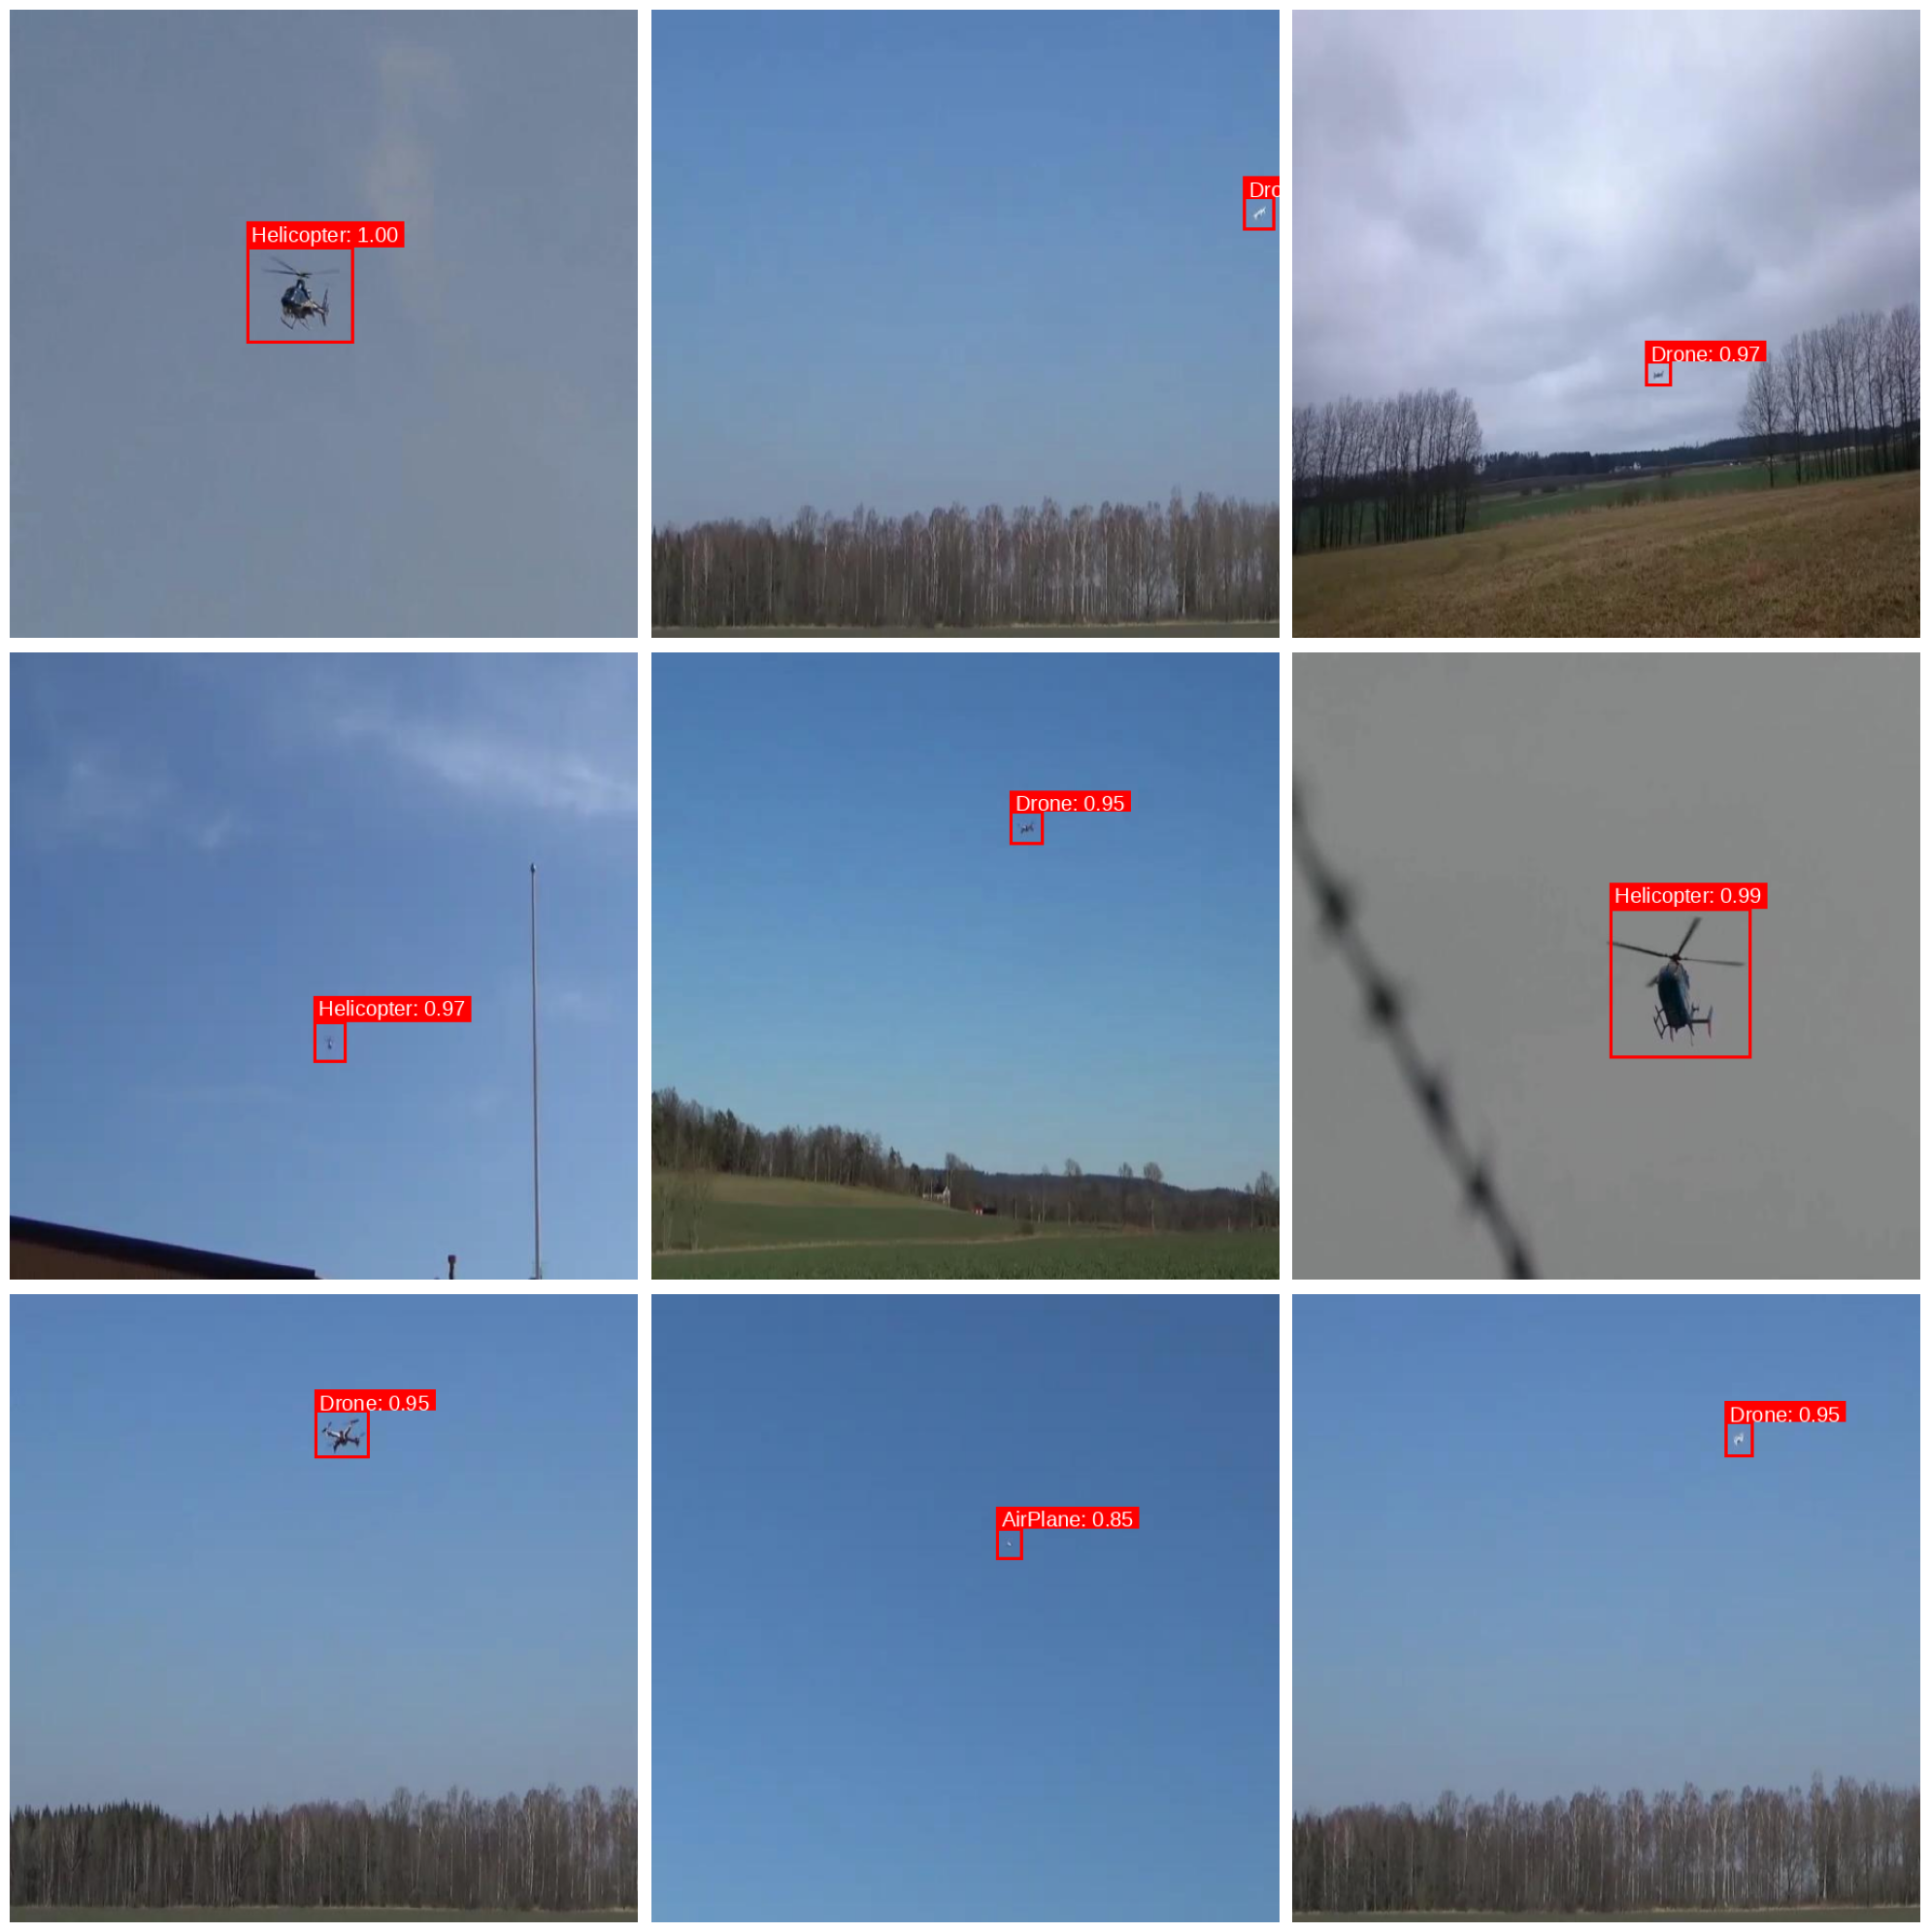

In [13]:
# --- Main Execution Block ---

def main():
    """Main function to run the entire pipeline."""
    config = DroneDetectionConfig()
    logger.info("Starting run with configuration: %s", config)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    logger.info(f"Using device: {device}")

    # Prepare datasets
    train_transform = get_transforms(is_train=True, img_size=config.IMG_SIZE)
    val_test_transform = get_transforms(is_train=False, img_size=config.IMG_SIZE)
    
    ds_train = DroneDataset(config.ROOT_DIR, split='train', transforms=train_transform)
    ds_val = DroneDataset(config.ROOT_DIR, split='valid', transforms=val_test_transform)
    ds_test = DroneDataset(config.ROOT_DIR, split='test', transforms=val_test_transform)
    logger.info(f"Datasets created: Train={len(ds_train)}, Validation={len(ds_val)}, Test={len(ds_test)}")

    # Create category mappings for visualization
    coco_train_instance = get_coco_instance(config.TRAIN_DIR)
    id_to_cat_map, _ = create_category_mappings(coco_train_instance)

    # Prepare DataLoaders
    dl_train = DataLoader(ds_train, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)
    dl_val = DataLoader(ds_val, batch_size=config.BATCH_SIZE * 2, shuffle=False, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)
    dl_test = DataLoader(ds_test, batch_size=config.BATCH_SIZE * 2, shuffle=False, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)

    # Model, Optimizer
    model = create_detection_model(num_classes=config.NUM_CLASSES)
    model.to(device)
    optimizer = optim.SGD(model.parameters(), lr=config.LEARNING_RATE, momentum=config.MOMENTUM, weight_decay=config.WEIGHT_DECAY)

    # Training loop
    for epoch in range(config.NUM_EPOCHS):
        avg_train_loss = train_one_epoch(model, optimizer, dl_train, device, epoch, config.BOX_REG_LOSS_WEIGHT)
        avg_val_loss, val_loss_comps = evaluate(model, dl_val, device, config.BOX_REG_LOSS_WEIGHT)

        logger.info(f"--- Epoch {epoch+1}/{config.NUM_EPOCHS} Summary ---")
        logger.info(f"  Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")
        for name, value in val_loss_comps.items():
            logger.info(f"    - Avg Val {name}: {value:.4f}")
            
    logger.info("Training finished.")

    # Save the final model
    torch.save(model.state_dict(), config.MODEL_SAVE_PATH)
    logger.info(f"Model saved to {config.MODEL_SAVE_PATH}")

    # Final evaluation on the test set
    logger.info("--- Final Evaluation on Test Set ---")
    test_loss, test_loss_comps = evaluate(model, dl_test, device, config.BOX_REG_LOSS_WEIGHT)
    logger.info(f"  Total Test Loss: {test_loss:.4f}")
    for name, value in test_loss_comps.items():
        logger.info(f"    - Avg Test {name}: {value:.4f}")

    # Visualize predictions on the test set
    logger.info("Visualizing model predictions on the test set...")
    visualize_model_predictions(model, ds_test, device, id_to_cat_map, config)


if __name__ == "__main__":
    main()

--- Starting Quick Final Evaluation ---
INFO: Instantiating configuration...
INFO: Creating model structure...
INFO: Loading saved model weights from 'fasterrcnn_drone_detector.pth'...
INFO: Model moved to device: cuda
INFO: Preparing the test data loader...
loading annotations into memory...
Done (t=0.21s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
INFO: Running final evaluation on the test set...


[Validation]: 100%|██████████| 38/38 [00:19<00:00,  1.93it/s]



--- Final Evaluation Results ---
  Total Test Loss: 0.0638
    - Avg Test loss_classifier: 0.0156
    - Avg Test loss_box_reg: 0.0389
    - Avg Test loss_objectness: 0.0008
    - Avg Test loss_rpn_box_reg: 0.0007

INFO: Visualizing model predictions...


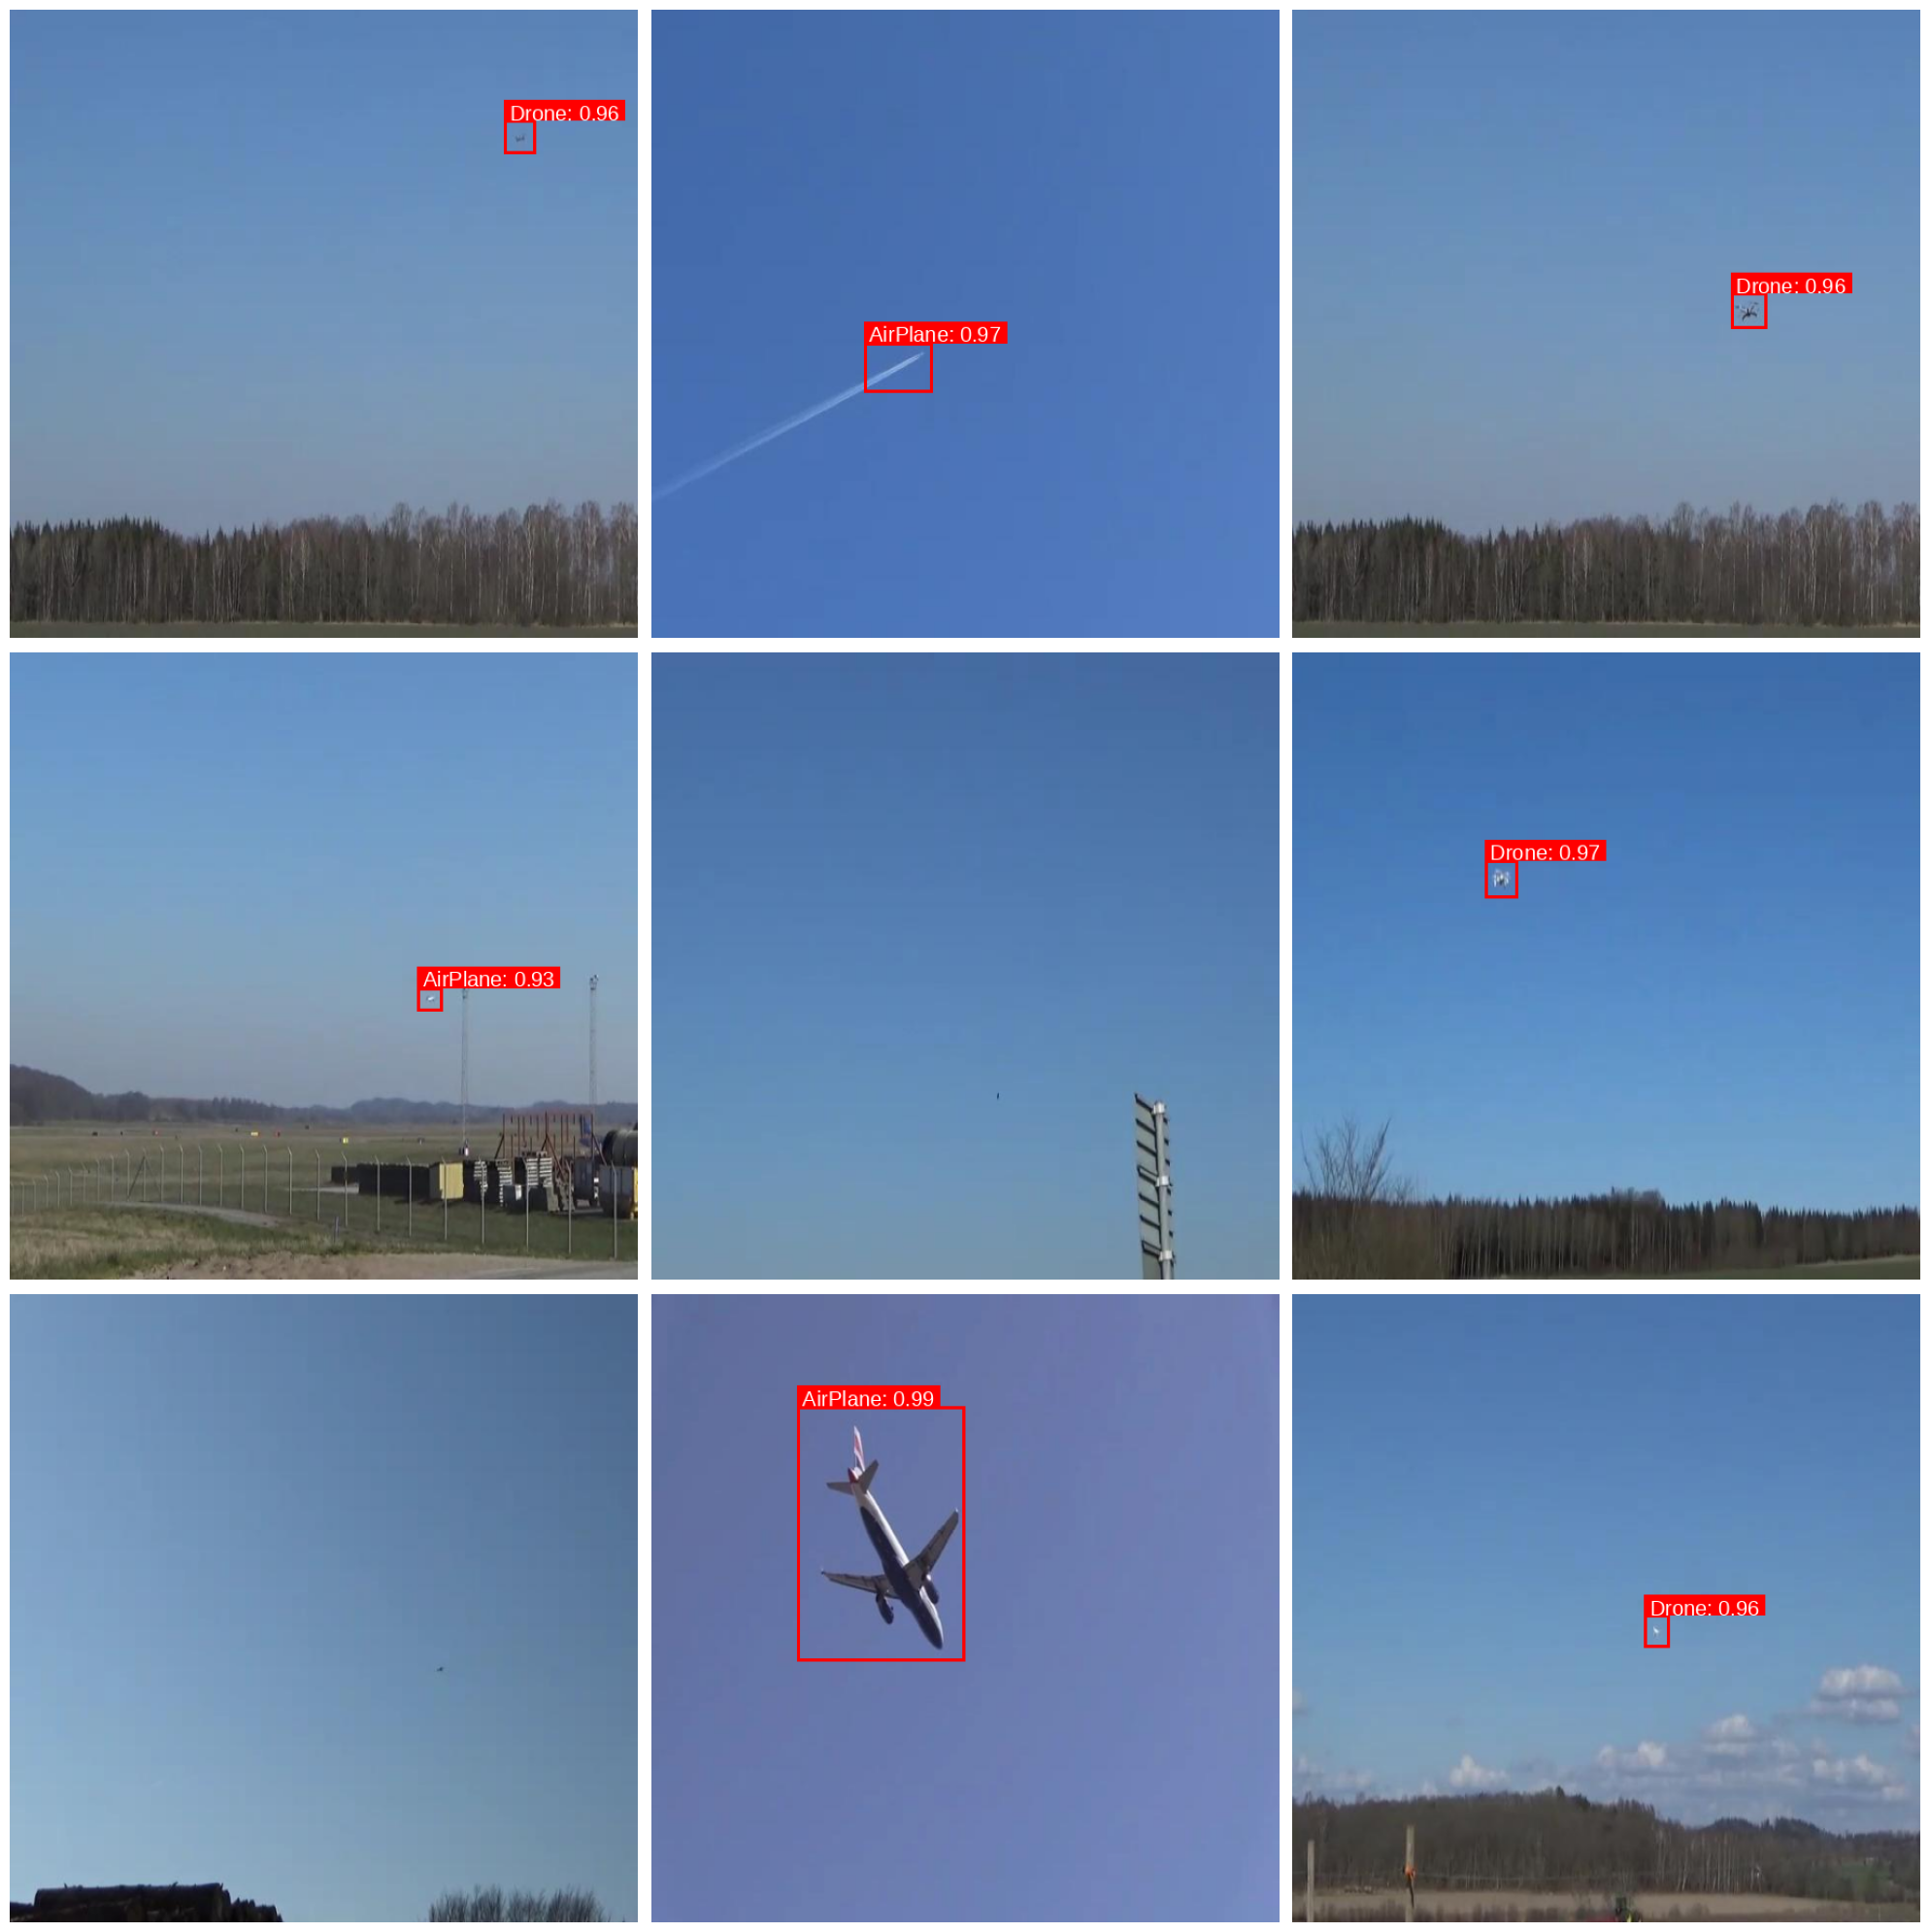

In [18]:
# --- Quick Final Evaluation ---
# This cell is run AFTER all the definition cells above have been executed.
# It loads the saved model and runs evaluation on the test set.

print("--- Starting Quick Final Evaluation ---")

# 1. Create the configuration object
# This was the missing step. We need to instantiate the config class.
print("INFO: Instantiating configuration...")
config = DroneDetectionConfig()

# 2. Re-create the model structure
print("INFO: Creating model structure...")
model = create_detection_model(num_classes=config.NUM_CLASSES)

# 3. Load the saved model weights
model_path = config.MODEL_SAVE_PATH
print(f"INFO: Loading saved model weights from '{model_path}'...")
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

# 4. Prepare the device and move the model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"INFO: Model moved to device: {device}")

# 5. Prepare the Test DataLoader
print("INFO: Preparing the test data loader...")
val_test_transform = get_transforms(is_train=False, img_size=config.IMG_SIZE)
# We need to re-create the 'id_to_cat_map' and dataset objects
coco_train_instance = get_coco_instance(config.TRAIN_DIR)
id_to_cat_map, _ = create_category_mappings(coco_train_instance)
ds_test = DroneDataset(config.ROOT_DIR, split='test', transforms=val_test_transform)
dl_test = DataLoader(ds_test, batch_size=config.BATCH_SIZE * 2, shuffle=False, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)

# 6. Run the evaluation function
print("INFO: Running final evaluation on the test set...")
test_loss, test_loss_comps = evaluate(model, dl_test, device, config.BOX_REG_LOSS_WEIGHT)

# 7. Print the final results in a clean format
print("\n" + "="*40)
print("--- Final Evaluation Results ---")
print(f"  Total Test Loss: {test_loss:.4f}")
for name, value in test_loss_comps.items():
    print(f"    - Avg Test {name}: {value:.4f}")
print("="*40 + "\n")

# 8. (Optional) Run the visualization as well
print("INFO: Visualizing model predictions...")
visualize_model_predictions(model, ds_test, device, id_to_cat_map, config)